## Data Pre-Process

In [1]:
# !usr/bin/env python
# -*- coding:utf-8 _*-
"""
@Author: Huiqiang Xie
@File: text_preprocess.py
@Time: 2021/3/31 22:14
"""
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 30 16:44:08 2020

@author: hx301
"""
import unicodedata
import re
from w3lib.html import remove_tags
import pickle
import argparse
import os
import json
from tqdm import tqdm

parser = argparse.ArgumentParser()
parser.add_argument('--input-data-dir', default='kordata/ko', type=str)
parser.add_argument('--output-train-dir', default='kordata/train_data.pkl', type=str)
parser.add_argument('--output-validation-dir', default='kordata/validation_data.pkl', type=str)
parser.add_argument('--output-test-dir', default='kordata/test_data.pkl', type=str)
parser.add_argument('--output-vocab', default='kordata/vocab.json', type=str)

SPECIAL_TOKENS = {
  '<PAD>': 0,
  '<START>': 1,
  '<END>': 2,
  '<UNK>': 3,
}

def cutted_data(cleaned, MIN_LENGTH=2, MAX_LENGTH=100):
    cutted_lines = list()
    for line in cleaned:
        length = len(line.split())
        if length > MIN_LENGTH and length < MAX_LENGTH:
            line = [word for word in line.split()]
            cutted_lines.append(' '.join(line))
    return cutted_lines

def cutted_data(cleaned, MIN_LENGTH=4, MAX_LENGTH=30):
    cutted_lines = list()
    for line in cleaned:
        length = len(line.split())
        if length > MIN_LENGTH and length < MAX_LENGTH:
            line = [word for word in line.split()]
            cutted_lines.append(' '.join(line))
    return cutted_lines

def process(text_path):
    fop = open(text_path, 'r', encoding='utf8')
    raw_data = fop.read()
    sentences = raw_data.strip().split('\n')
    raw_data_input = cutted_data(sentences) 
    fop.close()

    return raw_data_input


def tokenize(s, delim=' ',  add_start_token=True, add_end_token=True,
             punct_to_keep=None, punct_to_remove=None):
    """
    Tokenize a sequence, converting a string s into a list of (string) tokens by
    splitting on the specified delimiter. Optionally keep or remove certain
    punctuation marks and add start and end tokens.
    """
    if punct_to_keep is not None:
        for p in punct_to_keep:
            s = s.replace(p, '%s%s' % (delim, p))

    if punct_to_remove is not None:
        for p in punct_to_remove:
            s = s.replace(p, '')

    tokens = s.split(delim)
    if add_start_token:
        tokens.insert(0, '<START>')
    if add_end_token:
        tokens.append('<END>')
    return tokens


def build_vocab(sequences, token_to_idx = { }, min_token_count=1, delim=' ',
                punct_to_keep=None, punct_to_remove=None, ):
    token_to_count = {}

    for seq in sequences:
      seq_tokens = tokenize(seq, delim=delim, punct_to_keep=punct_to_keep,
                      punct_to_remove=punct_to_remove,
                      add_start_token=False, add_end_token=False)
      for token in seq_tokens:
        if token not in token_to_count:
          token_to_count[token] = 0
        token_to_count[token] += 1

    for token, count in sorted(token_to_count.items()):
      if count >= min_token_count:
        token_to_idx[token] = len(token_to_idx)

    return token_to_idx


def encode(seq_tokens, token_to_idx, allow_unk=False):
    seq_idx = []
    for token in seq_tokens:
      if token not in token_to_idx:
        if allow_unk:
          token = '<UNK>'
        else:
          raise KeyError('Token "%s" not in vocab' % token)
      seq_idx.append(token_to_idx[token])
    return seq_idx


def decode(seq_idx, idx_to_token, delim=None, stop_at_end=True):
    tokens = []
    for idx in seq_idx:
      tokens.append(idx_to_token[idx])
      if stop_at_end and tokens[-1] == '<END>':
        break
    if delim is None:
      return tokens
    else:
      return delim.join(tokens)


def main(args):
    data_dir = 'C:/Users/JH_Kang/Documents/chambit/'
    args.input_data_dir = data_dir + args.input_data_dir
    args.output_train_dir = data_dir + args.output_train_dir
    args.output_validation_dir = data_dir + args.output_validation_dir
    args.output_test_dir = data_dir + args.output_test_dir
    args.output_vocab = data_dir + args.output_vocab

    print(args.input_data_dir)
    sentences = []
    print('Preprocess Raw Text')
    for fn in tqdm(os.listdir(args.input_data_dir)):
        if not fn.endswith('.txt'): continue
        process_sentences = process(os.path.join(args.input_data_dir, fn))
        sentences += process_sentences

    # remove the same sentences
    a = {}
    for set in sentences:
        if set not in a:
            a[set] = 0
        a[set] += 1
    sentences = list(a.keys())
    print('Number of sentences: {}'.format(len(sentences)))
    
    print('Build Vocab')
    token_to_idx = build_vocab(
        sentences, SPECIAL_TOKENS,
        punct_to_keep=[';', ','], punct_to_remove=['?', '.']
    )

    vocab = {'token_to_idx': token_to_idx}
    print('Number of words in Vocab: {}'.format(len(token_to_idx)))

    # save the vocab
    if args.output_vocab != '':
        with open(args.output_vocab, 'w', encoding='utf-8') as f:
            json.dump(vocab, f, ensure_ascii=False)

    print('Start encoding txt')
    results = []
    for seq in tqdm(sentences):
        words = tokenize(seq, punct_to_keep=[';', ','], punct_to_remove=['?', '.'])
        tokens = [token_to_idx[word] for word in words]
        results.append(tokens)
    


    print('Writing Data')
    train_data = results[: round(len(results) * 0.8)]
    validation_data = results[round(len(results) * 0.8) : round(len(results) * 0.9)]
    test_data = results[round(len(results) * 0.9):]

    with open(args.output_train_dir, 'wb') as f:
        pickle.dump(train_data, f)
    with open(args.output_validation_dir, 'wb') as f:
        pickle.dump(validation_data, f)
    with open(args.output_test_dir, 'wb') as f:
        pickle.dump(test_data, f)

if __name__ == '__main__':
    args = parser.parse_args("")
    main(args)

C:/Users/JH_Kang/Documents/chambit/kordata/ko
Preprocess Raw Text


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Number of sentences: 148425
Build Vocab
Number of words in Vocab: 48665
Start encoding txt


100%|██████████| 148425/148425 [00:00<00:00, 333134.40it/s]

Writing Data


## Dataset

In [2]:
# !usr/bin/env python
# -*- coding:utf-8 _*-
"""
@Author: Huiqiang Xie
@File: EurDataset.py
@Time: 2021/3/31 23:20
"""

import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset

class KorDataset(Dataset):
    def __init__(self, split=Dataset):
        data_dir = 'C:/Users/JH_Kang/Documents/chambit/'
        with open(data_dir + 'kordata/{}_data.pkl'.format(split), 'rb') as f:
            self.data = pickle.load(f, encoding = 'utf-8')


    def __getitem__(self, index):
        sents = self.data[index]
        return  sents

    def __len__(self):
        return len(self.data)

def collate_data(batch):

    batch_size = len(batch)
    max_len = max(map(lambda x: len(x), batch))   # get the max length of sentence in current batch
    sents = np.zeros((batch_size, max_len), dtype=np.int64)
    sort_by_len = sorted(batch, key=lambda x: len(x), reverse=True)

    for i, sent in enumerate(sort_by_len):
        length = len(sent)
        sents[i, :length] = sent  # padding the questions

    return  torch.from_numpy(sents)

 ## Main Code (Train)

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 26 16:59:14 2020

@author: HQ Xie
"""
import os
import argparse
import time
import json
import torch
import random
import torch.nn as nn
import numpy as np
from utils import SNR_to_noise, initNetParams, train_step, val_step, train_mi
from dataset import KorDataset, collate_data
from models.transceiver import DeepSC
from models.mutual_info import Mine
from torch.utils.data import DataLoader
from tqdm import tqdm

parser = argparse.ArgumentParser()
parser.add_argument('--vocab-file', default='kordata/vocab.json', type=str)
parser.add_argument('--checkpoint-path', default='checkpoints/deepsc-Rayleigh', type=str)
parser.add_argument('--channel', default='Rayleigh', type=str, help = 'Please choose AWGN, Rayleigh, and Rician')
parser.add_argument('--MAX-LENGTH', default=100, type=int)
parser.add_argument('--MIN-LENGTH', default=2, type=int)
parser.add_argument('--d-model', default=128, type=int)
parser.add_argument('--dff', default=512, type=int)
parser.add_argument('--num-layers', default=4, type=int)
parser.add_argument('--num-heads', default=8, type=int)
parser.add_argument('--batch-size', default=128, type=int)
parser.add_argument('--epochs', default=100, type=int)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

def validate(epoch, args, net):
    valid_kor = KorDataset('validation')
    valid_iterator = DataLoader(valid_kor, batch_size=args.batch_size, num_workers=0,
                                pin_memory=True, collate_fn=collate_data)
    net.eval()
    pbar = tqdm(valid_iterator)
    total = 0
    with torch.no_grad():
        for sents in pbar:
            sents = sents.to(device)
            loss = val_step(net, sents, sents, 0.1, pad_idx,
                             criterion, args.channel)

            total += loss
            pbar.set_description(
                'Epoch: {}; Type: VAL; Loss: {:.5f}'.format(
                    epoch + 1, loss
                )
            )

    return total/len(valid_iterator)




def train(epoch, args, net, mi_net=None):
    train_kor= KorDataset('train')
    train_iterator = DataLoader(train_kor, batch_size=args.batch_size, num_workers=0,
                                pin_memory=True, collate_fn=collate_data)
    pbar = tqdm(train_iterator)
    
    noise_std = np.random.uniform(SNR_to_noise(5), SNR_to_noise(10), size=(1))
    running_loss = 0.0
    mutual_sum = 0.0
    for sents in pbar:
        sents = sents.to(device)
        
        
        if mi_net is not None:
            mi = train_mi(net, mi_net, sents, noise_std[0], pad_idx, mi_opt, args.channel)
            loss = train_step(net, sents, sents, noise_std[0], pad_idx,
                              optimizer, criterion, args.channel)
            pbar.set_description(
                'Epoch: {}; Type: Train; Loss: {:.5f}; MI {:.5f}'.format(
                    epoch + 1, loss, mi
                )
            )
            running_loss += loss
            mutual_sum += mi
        else:
            loss = train_step(net, sents, sents, noise_std[0], pad_idx,
                              optimizer, criterion, args.channel)
            pbar.set_description(
                'Epoch: {}; Type: Train; Loss: {:.5f}'.format(
                    epoch + 1, loss
                )
            )
            running_loss += loss
            
    record_train_loss = running_loss/len(train_iterator)
    mutual_info_value = mutual_sum/len(train_iterator)
    return record_train_loss, mutual_info_value


if __name__ == '__main__':
    # setup_seed(10)
    args = parser.parse_args("")
    args.vocab_file = 'C:/Users/JH_Kang/Documents/chambit/' + args.vocab_file
    """ preparing the dataset """
    vocab = json.load(open(args.vocab_file, 'rb'))
    token_to_idx = vocab['token_to_idx']
    num_vocab = len(token_to_idx)
    pad_idx = token_to_idx["<PAD>"]
    start_idx = token_to_idx["<START>"]
    end_idx = token_to_idx["<END>"]


    """ define optimizer and loss function """
    deepsc = DeepSC(args.num_layers, num_vocab, num_vocab,
                        num_vocab, num_vocab, args.d_model, args.num_heads,
                        args.dff, 0.1).to(device)
    mi_net = Mine().to(device)
    criterion = nn.CrossEntropyLoss(reduction = 'none')
    optimizer = torch.optim.Adam(deepsc.parameters(),
                                 lr=1e-4, betas=(0.9, 0.98), eps=1e-8, weight_decay = 5e-4)
    mi_opt = torch.optim.Adam(mi_net.parameters(), lr=1e-3)
    initNetParams(deepsc)
    
    record_train_loss = []
    record_val_loss = []
    record_mi = []
    for epoch in range(args.epochs):
        start = time.time()
        record_acc = 10

        train_result = train(epoch, args, deepsc, mi_net)
        avg_acc = validate(epoch, args, deepsc)
        


        if avg_acc < record_acc:
            if not os.path.exists(args.checkpoint_path):
                os.makedirs(args.checkpoint_path)
            with open(args.checkpoint_path + '/checkpoint_{}.pth'.format(str(epoch + 1).zfill(2)), 'wb') as f:
                torch.save(deepsc.state_dict(), f)
            record_acc = avg_acc
        record_train_loss.append(train_result[0])
        record_val_loss.append(avg_acc)
        record_mi.append(train_result[1])
        


Epoch: 1; Type: Train; Loss: 2.82727; MI -0.04901: 100%|██████████| 928/928 [03:57<00:00,  3.91it/s]
Epoch: 2; Type: VAL; Loss: 2.53019: 100%|██████████| 116/116 [00:03<00:00, 38.39it/s]
Epoch: 3; Type: Train; Loss: 2.18298; MI -0.82730: 100%|██████████| 928/928 [03:20<00:00,  4.63it/s]
Epoch: 3; Type: VAL; Loss: 2.30831: 100%|██████████| 116/116 [00:02<00:00, 38.70it/s]
Epoch: 4; Type: Train; Loss: 2.03442; MI -0.24363: 100%|██████████| 928/928 [03:20<00:00,  4.63it/s]
Epoch: 4; Type: VAL; Loss: 2.11532: 100%|██████████| 116/116 [00:03<00:00, 38.48it/s]
Epoch: 5; Type: Train; Loss: 1.90238; MI -0.57839: 100%|██████████| 928/928 [03:20<00:00,  4.63it/s]
Epoch: 5; Type: VAL; Loss: 1.77778: 100%|██████████| 116/116 [00:03<00:00, 37.53it/s]
Epoch: 6; Type: Train; Loss: 1.51131; MI -0.58602: 100%|██████████| 928/928 [03:20<00:00,  4.64it/s]
Epoch: 6; Type: VAL; Loss: 1.55557: 100%|██████████| 116/116 [00:03<00:00, 38.54it/s]
Epoch: 7; Type: Train; Loss: 2.07794; MI -0.80501: 100%|█████████

In [4]:
record_train_loss

[3.640456003104818,
 2.81010200365864,
 2.4964041765136966,
 2.3322068508072147,
 2.092758700123121,
 1.8706148166594834,
 1.745909148313362,
 1.7099388809553508,
 1.6763776792534466,
 1.6252929241364371,
 1.5126821726945967,
 1.468712354143118,
 1.456901805860729,
 1.433667946863791,
 1.4083816400761235,
 1.2383903577153026,
 1.3788556837444674,
 1.1851532259506399,
 1.2122556529296884,
 1.241187708516573,
 1.1316655203057775,
 1.0202742854839768,
 1.0138788089991129,
 0.9859901456611937,
 1.1334820191279567,
 1.0071508700734582,
 1.0933405004184822,
 0.8761994013370111,
 0.8986337664376559,
 0.9419844560967437,
 1.0223686026794643,
 0.8452544400532698,
 0.8045787419160378,
 0.842679043364679,
 0.9505807472521375,
 0.9018807188961012,
 0.8001494690583184,
 0.7826789821787127,
 0.7785130943139565,
 0.7449342718283678,
 0.8645251505076885,
 0.8455617954183755,
 0.7224666407203366,
 0.7658269493680062,
 0.7303461599773888,
 0.7053820041554242,
 0.7128179760906717,
 0.6419341509583695,
 0

In [5]:
record_val_loss

[3.0307031582141746,
 2.588764798024605,
 2.3732009149830917,
 2.1860803591793982,
 1.851245251195184,
 1.6276769103675053,
 1.508720153364642,
 1.431309234479378,
 1.4003790606712472,
 1.352947090206475,
 1.2780137062072754,
 1.2111141871789406,
 1.1622482147710076,
 1.1575316098229638,
 1.088680187176014,
 1.0657633003489724,
 1.0147875228832508,
 0.9781565121535597,
 0.9743418380104262,
 0.9283414087418852,
 0.9034975818518934,
 0.836279002756908,
 0.7915899167800772,
 0.774106090438777,
 0.7591962459786185,
 0.7598191674413353,
 0.740807026367763,
 0.7016414886918562,
 0.6673602256281622,
 0.6645322603912189,
 0.6573392502192793,
 0.630350317163714,
 0.5934803804446911,
 0.5932892170445673,
 0.5986467491963814,
 0.6212564085064263,
 0.5580218095203926,
 0.5754204746978037,
 0.5370784979955904,
 0.548122882586101,
 0.5249578277098721,
 0.527355988734755,
 0.5261150202874479,
 0.5180182356772751,
 0.49231917668005515,
 0.4876872540034097,
 0.498894392416395,
 0.4682059496127326,
 0.4

In [6]:
MI_result = [i*(-1) for i in record_mi]
MI_result

[0.02889833682283536,
 0.13821958631461742,
 0.4500206121652997,
 0.35071091214194894,
 0.5321891744107264,
 0.6133646683060917,
 0.5782548048180239,
 0.5174708291245945,
 0.44207335257067765,
 0.435508309092758,
 0.5276595586268552,
 0.5145865141189304,
 0.5021437337172443,
 0.4592866959242985,
 0.46358092235208587,
 0.6607436326107589,
 0.45162838568975183,
 0.64409272382357,
 0.5656632702187474,
 0.49687001250427343,
 0.6011870637985652,
 0.7294014626792793,
 0.6995446536818455,
 0.678344803316326,
 0.4818690730066135,
 0.5751582116916262,
 0.48382830311512126,
 0.753458651489225,
 0.6332290871389981,
 0.6026352721041647,
 0.49277870305653276,
 0.6941931205319947,
 0.7315687426719172,
 0.608984908667104,
 0.48587392630248233,
 0.49473252018977854,
 0.6138473489675028,
 0.6266911569340475,
 0.5834303932457134,
 0.625575514959878,
 0.50356968980411,
 0.5065396312495758,
 0.6567464075211821,
 0.6091389948951786,
 0.6527364924550056,
 0.6786272664522303,
 0.5991203743835976,
 0.73654399

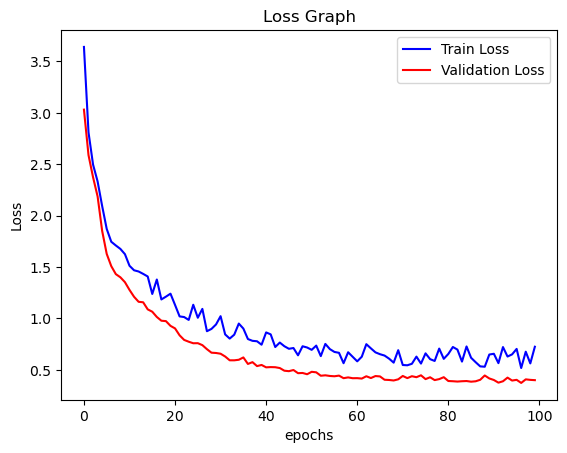

In [7]:
import matplotlib.pyplot as plt

# 첫 번째 데이터 그래프
plt.plot(record_train_loss, label='Train Loss', color='blue')

# 두 번째 데이터 그래프
plt.plot(record_val_loss, label='Validation Loss', color='red')

# 범례 추가
plt.legend()

# 그래프 제목
plt.title('Loss Graph')

# x축 라벨
plt.xlabel('epochs')

# y축 라벨
plt.ylabel('Loss')

# 그래프 보여주기
plt.show()

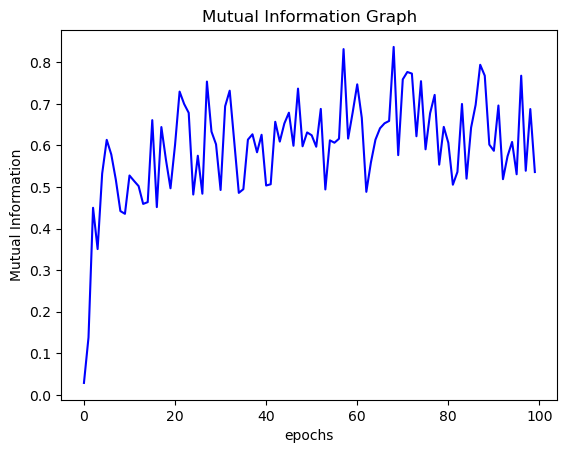

In [8]:
plt.plot(MI_result, color='blue')


# 그래프 제목
plt.title('Mutual Information Graph')

# x축 라벨
plt.xlabel('epochs')

# y축 라벨
plt.ylabel('Mutual Information')

# 그래프 보여주기
plt.show()

## Performance

In [9]:
# !usr/bin/env python
# -*- coding:utf-8 _*-
"""
@Author: Huiqiang Xie
@File: performance.py
@Time: 2021/4/1 11:48
"""
import os
import csv
import json
import torch
import argparse
import numpy as np
import pandas as pd
from dataset import KorDataset, collate_data
from models.transceiver import DeepSC
from torch.utils.data import DataLoader
from utils import BleuScore, SNR_to_noise, greedy_decode, SeqtoText
from tqdm import tqdm
from sklearn.preprocessing import normalize
from w3lib.html import remove_tags

parser = argparse.ArgumentParser()
parser.add_argument('--data-dir', default='kordata/train_data.pkl', type=str)
parser.add_argument('--vocab-file', default='kordata/vocab.json', type=str)
parser.add_argument('--checkpoint-path', default='checkpoints/deepsc-Rayleigh', type=str)
parser.add_argument('--channel', default='Rayleigh', type=str)
parser.add_argument('--MAX-LENGTH', default=30, type=int)
parser.add_argument('--MIN-LENGTH', default=4, type=int)
parser.add_argument('--d-model', default=128, type = int)
parser.add_argument('--dff', default=512, type=int)
parser.add_argument('--num-layers', default=4, type=int)
parser.add_argument('--num-heads', default=8, type=int)
parser.add_argument('--batch-size', default=64, type=int)
parser.add_argument('--epochs', default=2, type = int)
parser.add_argument('--bert-config-path', default='bert/cased_L-12_H-768_A-12/bert_config.json', type = str)
parser.add_argument('--bert-checkpoint-path', default='bert/cased_L-12_H-768_A-12/bert_model.ckpt', type = str)
parser.add_argument('--bert-dict-path', default='bert/cased_L-12_H-768_A-12/vocab.txt', type = str)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")





def performance(args, SNR, net):
    bleu_score_1gram = BleuScore(1, 0, 0, 0)
    bleu_score_2gram = BleuScore(0, 1, 0, 0)
    bleu_score_3gram = BleuScore(0, 0, 1, 0)
    bleu_score_4gram = BleuScore(0, 0, 0, 1)
    

    test_kor = KorDataset('test')
    test_iterator = DataLoader(test_kor, batch_size=args.batch_size, num_workers=0,
                               pin_memory=True, collate_fn=collate_data)

    StoT = SeqtoText(token_to_idx, end_idx)
    score1 = []
    score2 = []
    score3 = []
    score4 = []
    
    net.eval()
    
    with torch.no_grad():
        for epoch in range(args.epochs):
            Tx_word = []
            Rx_word = []
            Tx_for_save = []
            Rx_for_save = []

            for snr in tqdm(SNR):
                word = []
                target_word = []
                noise_std = SNR_to_noise(snr)

                for sents in test_iterator:

                    sents = sents.to(device) 
                    target = sents

                    out = greedy_decode(net, sents, noise_std, args.MAX_LENGTH, pad_idx,
                                        start_idx, args.channel)

                    sentences = out.cpu().numpy().tolist()
                    result_string = list(map(StoT.sequence_to_text, sentences))
                    word = word + result_string

                    target_sent = target.cpu().numpy().tolist()
                    result_string = list(map(StoT.sequence_to_text, target_sent))
                    target_word = target_word + result_string

                Tx_word.append(target_word)
                Rx_word.append(word)
               
                Tx_for_save.append(target_word)
                Rx_for_save.append(word)
                
                Tx_filename = f'Tx_{snr}.csv'
                Rx_filename = f'Rx_{snr}.csv'
            
                with open(Tx_filename, 'w', newline='', encoding='euc-kr') as csvfile:
                    writer = csv.writer(csvfile)
                    for my_list in Tx_for_save:
                        for item in my_list:
                            writer.writerow([item])
                         
                with open(Rx_filename, 'w', newline='', encoding='euc-kr') as csvfile:
                    writer = csv.writer(csvfile)
                    for my_list in Rx_for_save:
                        for item in my_list:
                            writer.writerow([item])  
                 
                Tx_for_save = []
                Rx_for_save = []          
                                                  
                         
            
                
            bleu_score1 = []
            bleu_score2 = []
            bleu_score3 = []
            bleu_score4 = []
            
            
            for sent1, sent2 in zip(Tx_word, Rx_word):
                # 1-gram
                bleu_score1.append(bleu_score_1gram.compute_blue_score(sent1, sent2)) # 7*num_sent
                # 2-gram
                bleu_score2.append(bleu_score_2gram.compute_blue_score(sent1, sent2)) # 7*num_sent
                # 3-gram
                bleu_score3.append(bleu_score_3gram.compute_blue_score(sent1, sent2)) # 7*num_sent
                # 4-gram
                bleu_score4.append(bleu_score_4gram.compute_blue_score(sent1, sent2)) # 7*num_sent
                

            bleu_score1 = np.array(bleu_score1)
            bleu_score2 = np.array(bleu_score2)
            bleu_score3 = np.array(bleu_score3)
            bleu_score4 = np.array(bleu_score4)
            
            
            bleu_score1 = np.mean(bleu_score1, axis=1)
            bleu_score2 = np.mean(bleu_score2, axis=1)
            bleu_score3 = np.mean(bleu_score3, axis=1)
            bleu_score4 = np.mean(bleu_score4, axis=1)
            
            score1.append(bleu_score1)
            score2.append(bleu_score2)
            score3.append(bleu_score3)
            score4.append(bleu_score4)
            



    score1 = np.mean(np.array(score1), axis=0)
    score2 = np.mean(np.array(score2), axis=0)
    score3 = np.mean(np.array(score3), axis=0)
    score4 = np.mean(np.array(score4), axis=0)
    


    return score1, score2, score3, score4

if __name__ == '__main__':
    args = parser.parse_args("")
    SNR = [0, 3, 6 ,9, 12, 15, 18]

    args.vocab_file = 'C:/Users/JH_Kang/Documents/chambit/' + args.vocab_file
    vocab = json.load(open(args.vocab_file, 'rb'))
    token_to_idx = vocab['token_to_idx']
    idx_to_token = dict(zip(token_to_idx.values(), token_to_idx.keys()))
    num_vocab = len(token_to_idx)
    pad_idx = token_to_idx["<PAD>"]
    start_idx = token_to_idx["<START>"]
    end_idx = token_to_idx["<END>"]

    """ define optimizer and loss function """
    deepsc = DeepSC(args.num_layers, num_vocab, num_vocab,
                        num_vocab, num_vocab, args.d_model, args.num_heads,
                        args.dff, 0.1).to(device)

    model_paths = []
    for fn in os.listdir(args.checkpoint_path):
        if not fn.endswith('.pth'): continue
        idx = int(os.path.splitext(fn)[0].split('_')[-1])  # read the idx of image
        model_paths.append((os.path.join(args.checkpoint_path, fn), idx))

    model_paths.sort(key=lambda x: x[1])  # sort the image by the idx

    model_path, _ = model_paths[-1]
    checkpoint = torch.load(model_path)
    deepsc.load_state_dict(checkpoint)
    print('model load!')

    bleu_score = performance(args, SNR, deepsc)
    print(bleu_score)

    


model load!


100%|██████████| 7/7 [03:51<00:00, 33.03s/it]
c:\Users\JH_Kang\anaconda3\envs\capstone\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\JH_Kang\anaconda3\envs\capstone\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\JH_Kang\anaconda3\envs\capstone\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of 

(array([0.51203671, 0.65162221, 0.76066985, 0.80778982, 0.82886801,
       0.85939777, 0.86268942]), array([0.38921968, 0.54209593, 0.66458928, 0.72221881, 0.74678525,
       0.78202401, 0.78632793]), array([0.32015902, 0.46880477, 0.59007187, 0.65093229, 0.67618429,
       0.71179966, 0.71626143]), array([0.2692393 , 0.40945247, 0.52408946, 0.5846749 , 0.6092212 ,
       0.64376311, 0.64772632]))


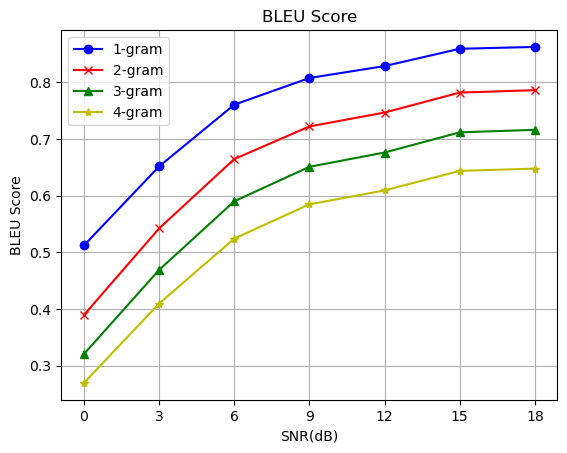

In [10]:
import matplotlib.pyplot as plt
# 선 그래프 그리기
plt.plot(SNR, bleu_score[0], marker='o', linestyle='-', color='b', label='1-gram')
plt.plot(SNR, bleu_score[1], marker='x', linestyle='-', color='r', label='2-gram')
plt.plot(SNR, bleu_score[2], marker='^', linestyle='-', color='g', label='3-gram')
plt.plot(SNR, bleu_score[3], marker='*', linestyle='-', color='y', label='4-gram')

# x 축 범위와 간격 설정
plt.xticks(range(0, 19, 3))

# 그래프 제목과 축 레이블 추가
plt.title('BLEU Score')
plt.xlabel('SNR(dB)')
plt.ylabel('BLEU Score')

# 그리드 추가
plt.grid(True)

plt.legend()

# 그래프 표시
plt.show()